# Spatial Analysis

### Imports

In [4]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
from IPython.display import display, Markdown

### Define Paths

In [5]:
CWD = Path.cwd()
ROOT = CWD.parent if CWD.name.lower() == "notebooks" else CWD

PROCESSED = ROOT / "data" / "processed"
OUTPUTS = ROOT / "outputs"

SPATIAL_DIR = OUTPUTS / "spatial"
FIGURES_SPATIAL = SPATIAL_DIR / "figures"
TABLES_SPATIAL = SPATIAL_DIR / "tables"

for p in [SPATIAL_DIR, FIGURES_SPATIAL, TABLES_SPATIAL]:
    p.mkdir(parents=True, exist_ok=True)

print("Python:", sys.version.split()[0])
print("FIGURES_SPATIAL:", FIGURES_SPATIAL)
print("TABLES_SPATIAL:", TABLES_SPATIAL)

Python: 3.11.9
FIGURES_SPATIAL: C:\Users\danci\Interconnection-Queue-Intelligence\Interconnection-Queue-Intelligence-1\outputs\spatial\figures
TABLES_SPATIAL: C:\Users\danci\Interconnection-Queue-Intelligence\Interconnection-Queue-Intelligence-1\outputs\spatial\tables


### Load Processed Queue Data

In [6]:
public = pd.read_csv(PROCESSED / "public_queue_clean_combined.csv")
c15 = pd.read_csv(PROCESSED / "cluster15_clean_combined.csv")
c14 = pd.read_csv(PROCESSED / "cluster14_clean.csv")

display(pd.DataFrame({
    "dataset": ["public", "cluster15", "cluster14"],
    "rows": [len(public), len(c15), len(c14)],
}))

,dataset,rows
0,public,2290
1,cluster15,170
2,cluster14,363


### Filter to California

In [15]:
def filter_ca(df):
    if "state" in df.columns:
        return df[df["state"].str.upper().eq("CA")].copy()
    return df.copy()

public_ca = filter_ca(public)
c15_ca = filter_ca(c15)
c14_ca = filter_ca(c14)

display(pd.DataFrame({
    "dataset": ["public_ca", "cluster15_ca", "cluster14_ca"],
    "rows": [len(public_ca), len(c15_ca), len(c14_ca)],
}))

,dataset,rows
0,public_ca,2076
1,cluster15_ca,147
2,cluster14_ca,363


### Load California County Geometries

In [16]:
ca_counties = gpd.read_file(
    "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_500k.zip"
)

ca_counties = ca_counties[ca_counties["STATEFP"] == "06"].copy()
ca_counties["county"] = ca_counties["NAME"].str.upper().str.strip()

ca_counties = ca_counties[["county", "geometry"]]

### Helpers

In [17]:
def norm_county_series(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
         .str.replace(" County", "", regex=False)
         .str.strip()
         .str.upper()
         .replace({"NAN": np.nan})
    )

def county_mw(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """Sum MW by county -> county, mw_sum, label"""
    if "county" not in df.columns:
        return pd.DataFrame(columns=["county", "mw_sum", "label"])

    tmp = df.copy()
    tmp["county"] = norm_county_series(tmp["county"])
    tmp["mw_poi"] = pd.to_numeric(tmp.get("mw_poi", np.nan), errors="coerce")

    out = (
        tmp.groupby("county")["mw_poi"]
           .sum(min_count=1)
           .fillna(0)
           .rename("mw_sum")
           .reset_index()
    )
    out["label"] = label
    return out

def county_withdraw_share_resolved_mw(public_df: pd.DataFrame) -> pd.DataFrame:
    """
    Public only: withdrawn / (withdrawn + completed) in MW, by county.
    Returns county, withdraw_share, resolved_mw.
    """
    req = {"county", "sheet_outcome", "mw_poi"}
    missing = req - set(public_df.columns)
    if missing:
        raise ValueError(f"public_df missing required columns: {missing}")

    tmp = public_df.copy()
    tmp["county"] = norm_county_series(tmp["county"])
    tmp["mw_poi"] = pd.to_numeric(tmp["mw_poi"], errors="coerce")

    resolved = tmp[tmp["sheet_outcome"].isin(["withdrawn", "completed"])].copy()

    piv = (
        resolved.pivot_table(
            index="county",
            columns="sheet_outcome",
            values="mw_poi",
            aggfunc="sum",
            fill_value=0
        )
        .reset_index()
    )

    withdrawn = piv["withdrawn"] if "withdrawn" in piv.columns else 0
    completed = piv["completed"] if "completed" in piv.columns else 0
    piv["resolved_mw"] = withdrawn + completed

    piv["withdraw_share"] = np.where(
        piv["resolved_mw"] > 0,
        withdrawn / piv["resolved_mw"],
        np.nan
    )

    return piv[["county", "withdraw_share", "resolved_mw"]]

def clean_poi(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
         .str.replace(r"\s+", " ", regex=True)
         .str.strip()
         .replace({"NAN": np.nan})
    )

def top_poi_mw(df: pd.DataFrame, label: str, top_n: int = 20) -> pd.DataFrame:
    """Sum MW by POI -> poi, mw_sum, label"""
    if "poi" not in df.columns:
        return pd.DataFrame(columns=["poi", "mw_sum", "label"])

    tmp = df.copy()
    tmp["poi"] = clean_poi(tmp["poi"])
    tmp["mw_poi"] = pd.to_numeric(tmp.get("mw_poi", np.nan), errors="coerce")

    out = (
        tmp.groupby("poi")["mw_poi"]
           .sum(min_count=1)
           .fillna(0)
           .sort_values(ascending=False)
           .head(top_n)
           .rename("mw_sum")
           .reset_index()
    )
    out["label"] = label
    return out

In [18]:
ca_counties = ca_counties.copy()
ca_counties["county"] = norm_county_series(ca_counties["county"])

### 1) Public Queue — Active MW by County (Choropleth)

In [19]:
pub_active = public_ca[public_ca["sheet_outcome"] == "active"].copy()
pub_cnty = county_mw(pub_active, "public_active")
gdf_pub = ca_counties.merge(pub_cnty, on="county", how="left").fillna({"mw_sum": 0})

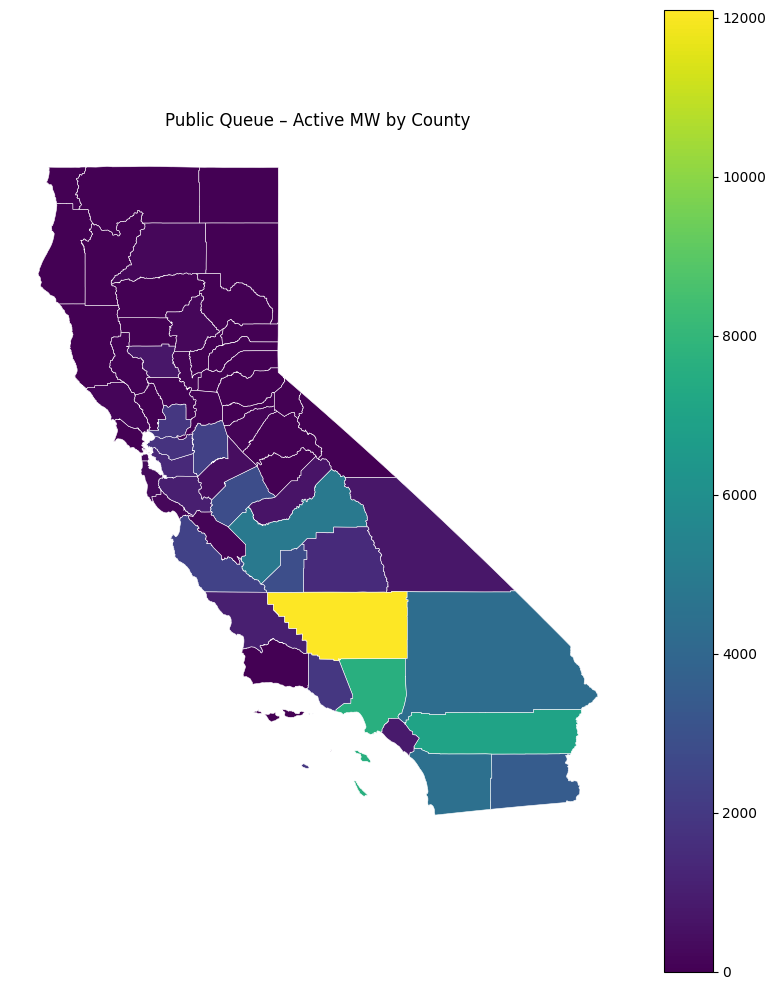

**Top counties by active MW (public):**

,county,mw_sum,label
8,KERN,12099.98,public_active
12,LOS ANGELES,7636.00,public_active
18,RIVERSIDE,7012.00,public_active
5,FRESNO,4883.28,public_active
22,SAN DIEGO,4426.41,public_active
21,SAN BERNARDINO,4255.00,public_active
6,IMPERIAL,3450.44,public_active
9,KINGS,2879.10,public_active
14,MERCED,2835.00,public_active
15,MONTEREY,2370.00,public_active


In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
gdf_pub.plot(
    column="mw_sum",
    cmap="viridis",
    linewidth=0.4,
    ax=ax,
    edgecolor="white",
    legend=True
)

ax.set_title("Public Queue – Active MW by County")
ax.axis("off")

plt.tight_layout()
plt.savefig(FIGURES_SPATIAL / "06a_public_active_mw_by_county.png", dpi=200)
plt.show()

display(Markdown("**Top counties by active MW (public):**"))
display(pub_cnty.sort_values("mw_sum", ascending=False).head(15))

### 2) Public Queue — Withdrawal Share by County (MW-based, Resolved)

In [21]:
pub_with = county_withdraw_share_resolved_mw(public_ca)
gdf_with = ca_counties.merge(pub_with, on="county", how="left")

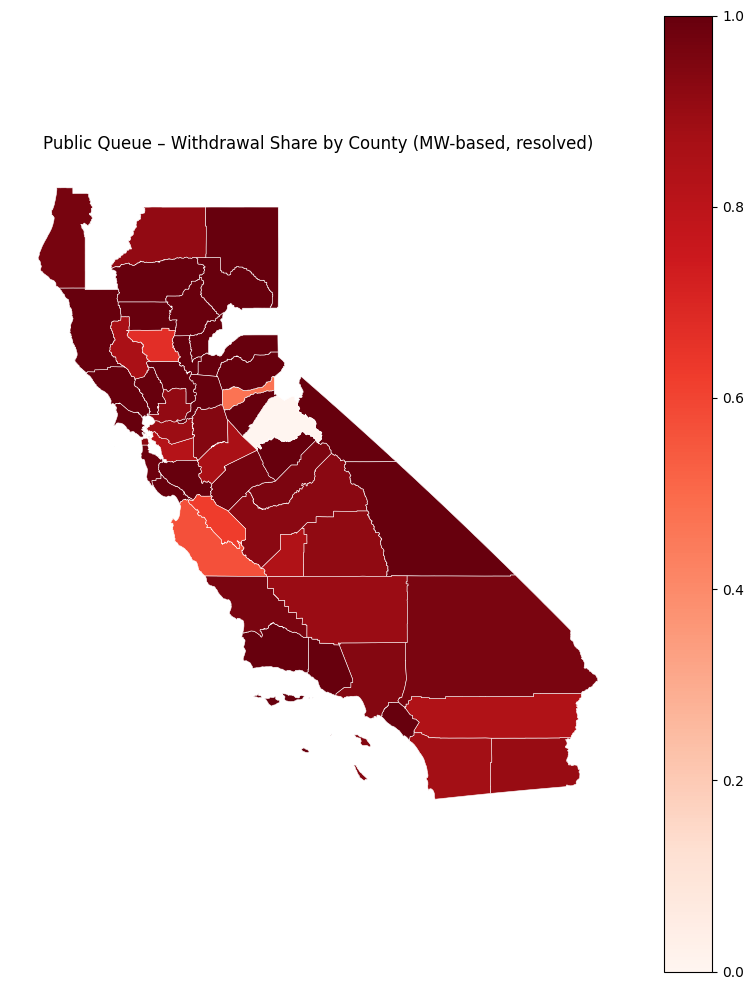

**Highest withdrawal-share counties (resolved MW only):**

sheet_outcome,county,withdraw_share,resolved_mw
1,ALAMEDA COUNTY,1.0,150.000
4,CALAVERAS,1.0,100.000
11,GLENN,1.0,237.000
8,EL DORADO,1.0,160.500
5,CHURCHILL/PERSHING,1.0,364.200
10,FRESNO COUNTY,1.0,250.000
23,LAKE/SONOMA,1.0,201.000
24,LASSEN,1.0,318.018
20,KINGS/KERN,1.0,20.000
17,KERN/INYO,1.0,120.000


In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
gdf_with.plot(
    column="withdraw_share",
    cmap="Reds",
    linewidth=0.4,
    ax=ax,
    edgecolor="white",
    legend=True,
    vmin=0, vmax=1
)

ax.set_title("Public Queue – Withdrawal Share by County (MW-based, resolved)")
ax.axis("off")

plt.tight_layout()
plt.savefig(FIGURES_SPATIAL / "06b_public_withdraw_share_by_county.png", dpi=200)
plt.show()

display(Markdown("**Highest withdrawal-share counties (resolved MW only):**"))
display(pub_with.sort_values("withdraw_share", ascending=False).head(15))

### 3) Top POI Concentration (MW) — Public Active vs Cluster 15 Active vs Cluster 14 Intake

In [23]:
t_pub = top_poi_mw(public_ca[public_ca["sheet_outcome"] == "active"], "public_active", top_n=30)
t_15  = top_poi_mw(c15_ca[c15_ca["sheet_outcome"] == "active"], "cluster15_active", top_n=30)
t_14  = top_poi_mw(c14_ca, "cluster14_intake", top_n=30)

union = pd.concat([t_pub, t_15, t_14], ignore_index=True)

In [24]:
pois = (
    union.groupby("poi")["mw_sum"]
         .sum()
         .sort_values(ascending=False)
         .head(15)
         .index
         .tolist()
)

def series(label):
    s = union[union["label"] == label].set_index("poi")["mw_sum"]
    return s.reindex(pois).fillna(0).values

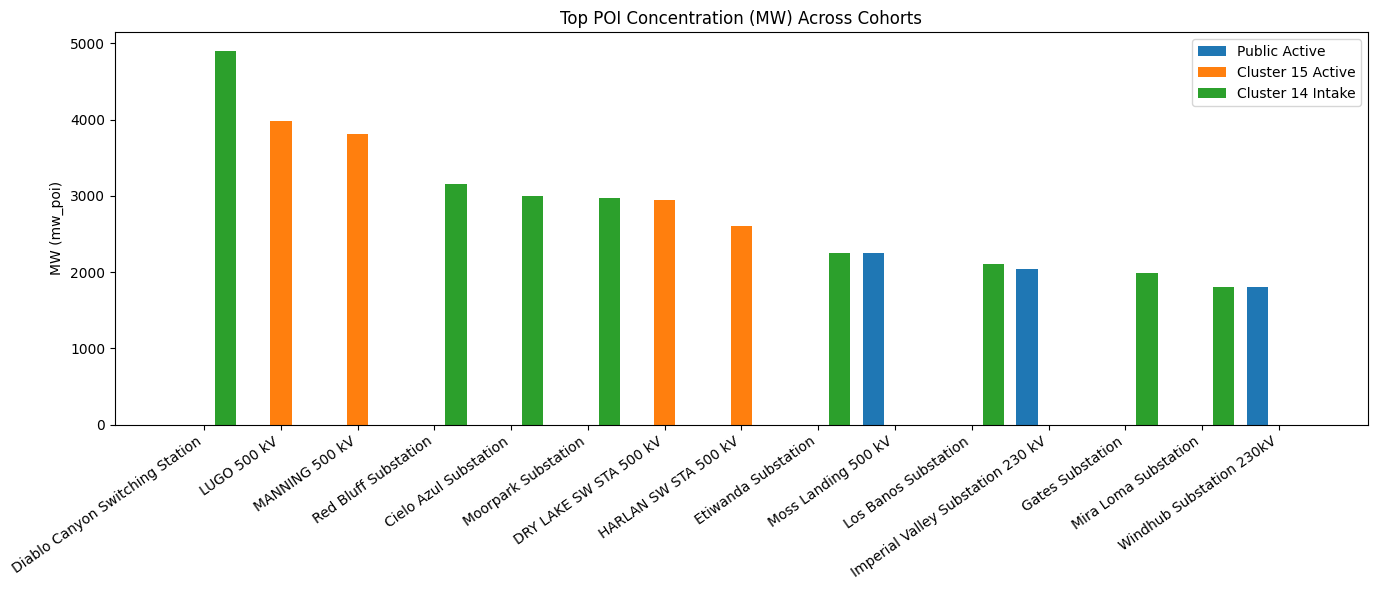

**Top POIs table (by cohort):**

,poi,mw_sum,label
60,Diablo Canyon Switching Station,4900.000,cluster14_intake
61,Red Bluff Substation,3150.000,cluster14_intake
62,Cielo Azul Substation,3000.000,cluster14_intake
63,Moorpark Substation,2975.000,cluster14_intake
64,Etiwanda Substation,2250.000,cluster14_intake
65,Los Banos Substation,2100.000,cluster14_intake
66,Gates Substation,1989.910,cluster14_intake
67,Mira Loma Substation,1800.000,cluster14_intake
68,Whirlwind Substation,1750.000,cluster14_intake
69,Midway Substation,1667.090,cluster14_intake


In [25]:
x = np.arange(len(pois))
w = 0.28

plt.figure(figsize=(14, 6))
plt.bar(x - w, series("public_active"), width=w, label="Public Active")
plt.bar(x,     series("cluster15_active"), width=w, label="Cluster 15 Active")
plt.bar(x + w, series("cluster14_intake"), width=w, label="Cluster 14 Intake")

plt.xticks(x, pois, rotation=35, ha="right")
plt.ylabel("MW (mw_poi)")
plt.title("Top POI Concentration (MW) Across Cohorts")
plt.legend()

plt.tight_layout()
plt.savefig(FIGURES_SPATIAL / "06c_top_poi_concentration_mw.png", dpi=200)
plt.show()

display(Markdown("**Top POIs table (by cohort):**"))
display(union.sort_values(["label","mw_sum"], ascending=[True, False]).head(40))